In [1]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
data_path = '/kaggle/input/image-dataset/training_data.pickle'

with open(data_path, 'rb') as f:
    data = pickle.load(f)
print("Databse loaded successfully")

Databse loaded successfully


In [3]:
images = []
labels = []

for item in data:
    img_array, label = item  # Assuming each item is a tuple/list of (image_array, label)
    images.append(img_array)
    labels.append(label)

In [4]:
labe = LabelEncoder()
# Encode 'F' as 0 and 'M' as 1
y = labe.fit_transform(labels)

In [5]:
IMG_SIZE = 224  
processed_img = []

for img in images:
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize the image to 128x128
    if len(img.shape) == 2:  # If the image is grayscale (2D array)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB (3 channels)
    processed_img.append(img)

# Convert processed images to a numpy array
X = np.array(processed_img) / 255.0

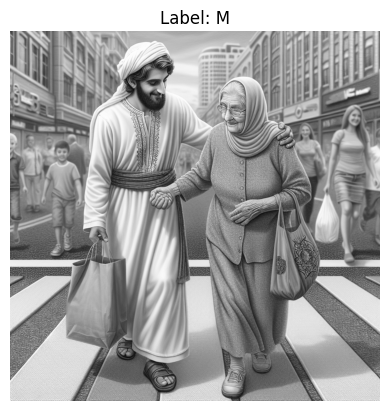

In [6]:
# Display a random image from the dataset
index = np.random.randint(0, len(images))  # Randomly choose an index
plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB for correct color display
plt.title(f"Label: {labels[index]}")
plt.axis('off')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# freeze the base model
base_model.trainable = True

# Freeze all layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False


In [11]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(BatchNormalization())  # Batch normalization
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

In [12]:
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [14]:
# Handle class imbalance
class_weights = {0: 2.33, 1: 1.0} 

In [15]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=200,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731044233.673699     103 service.cc:145] XLA service 0x7fa604018b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731044233.673756     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731044233.673761     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/100 ━━━━━━━━━━━━━━━━━━━━ 35:06 21s/step - accuracy: 0.4688 - loss: 2.2286

I0000 00:00:1731044249.644267     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 594ms/step - accuracy: 0.5814 - loss: 1.9987 - val_accuracy: 0.2895 - val_loss: 3.1580 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 328ms/step - accuracy: 0.7240 - loss: 1.2759 - val_accuracy: 0.8108 - val_loss: 0.8281 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 329ms/step - accuracy: 0.7955 - loss: 0.9736 - val_accuracy: 0.8722 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step - accuracy: 0.8133 - loss: 0.8094 - val_accuracy: 0.8446 - val_loss: 0.7343 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 327ms/step - accuracy: 0.8421 - loss: 0.6947 - val_accuracy: 0.8772 - val_loss: 0.4538 - learning_rate: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step - accuracy: 0.8490 - loss: 0.6278 - val_accuracy: 0.8960 - val_loss: 0.3758 - learning_rate: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step - accuracy: 0.8646 -

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9194 - loss: 0.2973
Test Loss: 0.300687700510025, Test Accuracy: 0.9135338068008423


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step
True Negatives: 174
False Positives: 40
False Negatives: 29
True Positives: 555


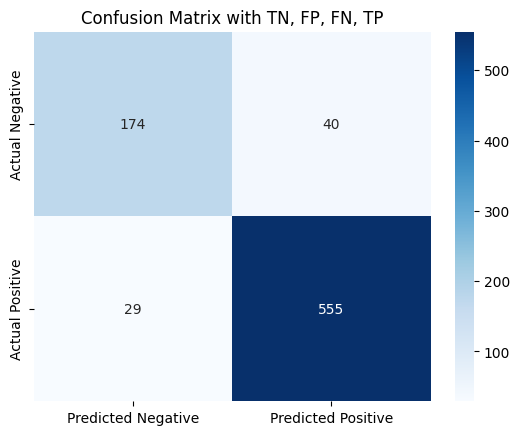

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting classes based on the threshold
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

# Generating the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Extract True Negative, False Positive, False Negative, and True Positive
TN, FP, FN, TP = cm.ravel()

# Displaying the values
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Positives: {TP}")

# Plotting the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix with TN, FP, FN, TP')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step


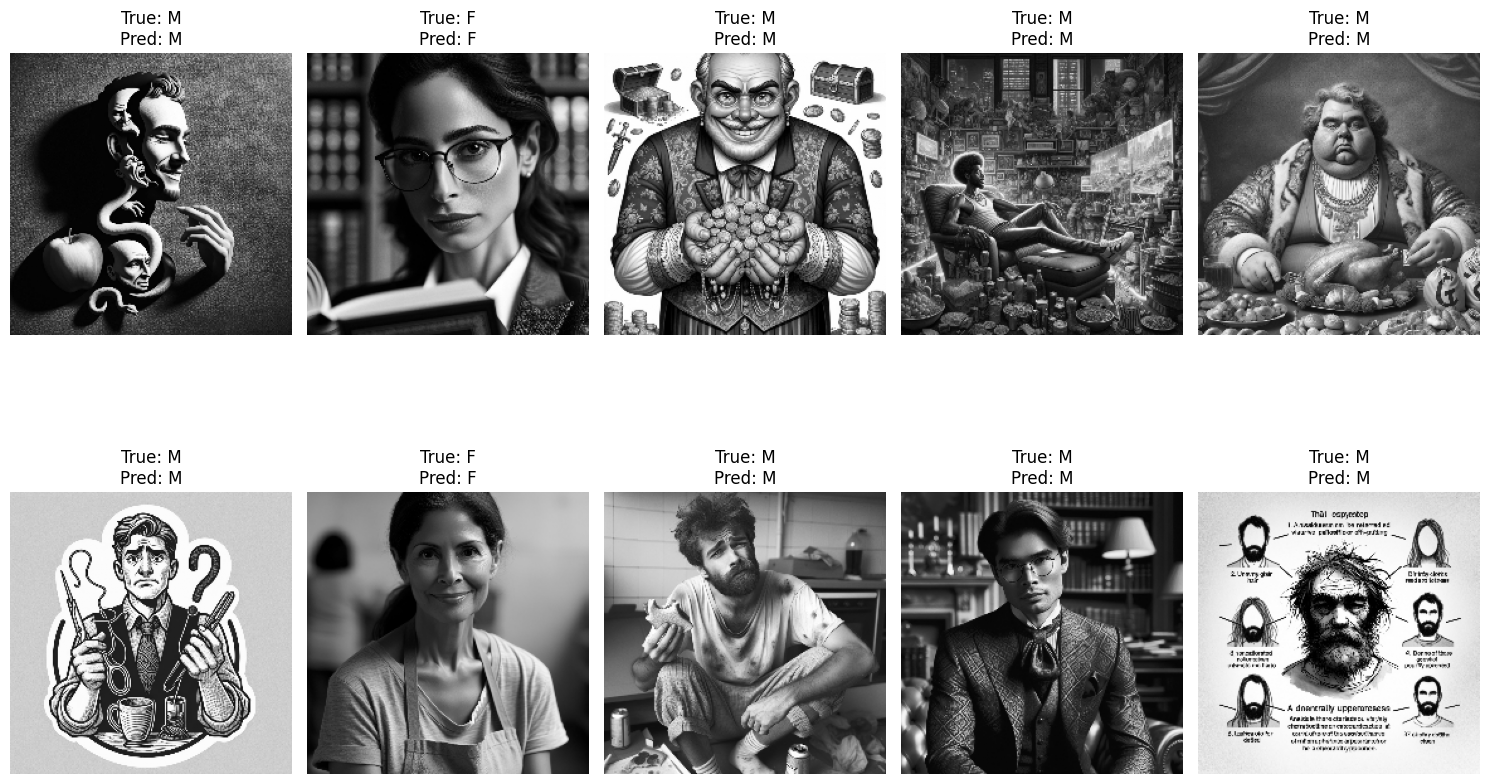

In [18]:
def display_predictions(images, true_labels, predictions, num_images=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        
        # Get the predicted class
        predicted_class = 'M' if predictions[i] > 0.5 else 'F'
        true_class = 'M' if true_labels[i] == 1 else 'F'
        
        plt.title(f'True: {true_class}\nPred: {predicted_class}')
    
    plt.tight_layout()
    plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Display the first 10 predictions
display_predictions(X_test, y_test, predictions)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


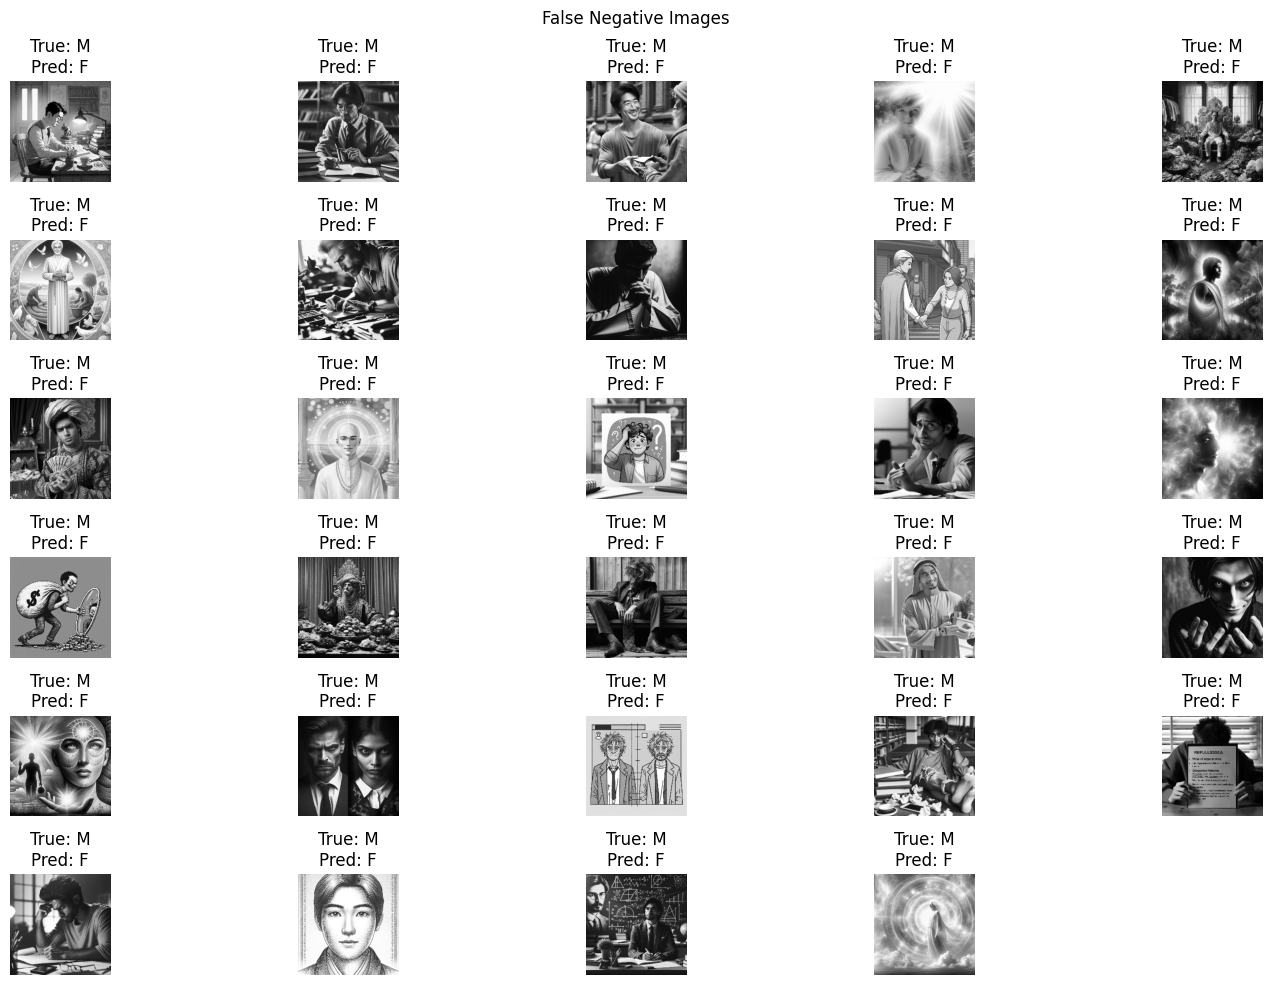

In [19]:
import matplotlib.pyplot as plt

def display_false_negatives(images, true_labels, predictions):
    # List to store False Negatives
    false_negatives = []
    
    # Iterate through predictions to identify False Negatives
    for i in range(len(predictions)):
        if true_labels[i] == 1 and predictions[i] < 0.5:  # False Negative
            false_negatives.append((images[i], true_labels[i], predictions[i]))

    # Display all False Negative images
    plt.figure(figsize=(15, 10))
    num_images = len(false_negatives)  # Display all FNs
    
    for i in range(num_images):
        plt.subplot((num_images // 5) + 1, 5, i + 1)  # Dynamically arrange grid based on FN count
        img, true_label, pred = false_negatives[i]
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.axis('off')
        
        # Determine true and predicted class names
        predicted_class = 'M' if pred > 0.5 else 'F'
        true_class = 'M' if true_label == 1 else 'F'
        
        plt.title(f'True: {true_class}\nPred: {predicted_class}')
    
    plt.suptitle("False Negative Images")
    plt.tight_layout()
    plt.show()

# Make predictions on the test set
predictions = model.predict(X_test).flatten()  # Flatten to ensure correct shape for comparison

# Display all False Negatives
display_false_negatives(X_test, y_test, predictions)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


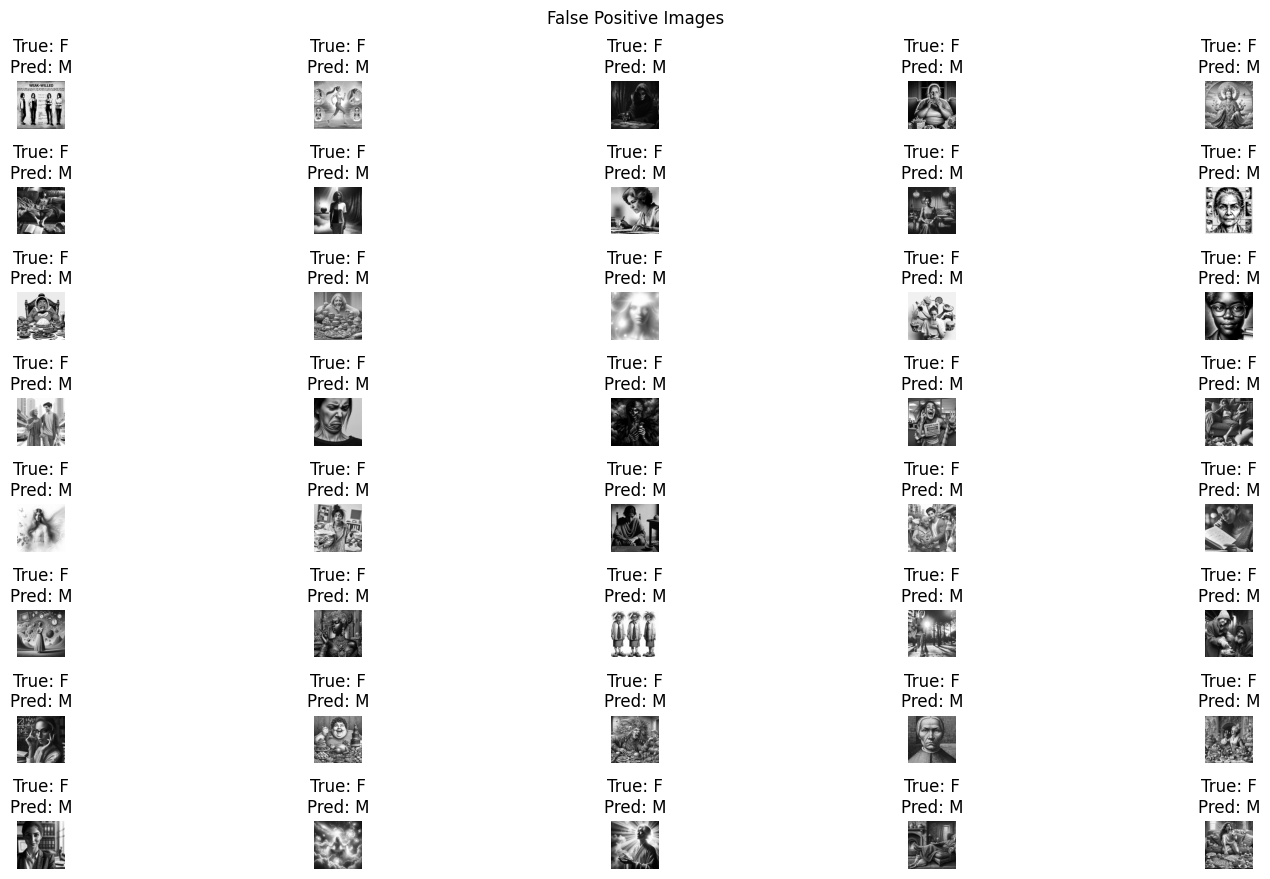

In [20]:
import matplotlib.pyplot as plt

def display_false_positives(images, true_labels, predictions):
    # List to store False Positives
    false_positives = []
    
    # Iterate through predictions to identify False Positives
    for i in range(len(predictions)):
        if true_labels[i] == 0 and predictions[i] > 0.5:  # False Positive
            false_positives.append((images[i], true_labels[i], predictions[i]))

    # Display all False Negative images
    plt.figure(figsize=(15, 10))
    num_images = len(false_positives)  # Display all FPs
    
    for i in range(num_images):
        plt.subplot((num_images // 5) + 1, 5, i + 1)  # Dynamically arrange grid based on FP count
        img, true_label, pred = false_positives[i]
        plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
        plt.axis('off')
        
        # Determine true and predicted class names
        predicted_class = 'M' if pred > 0.5 else 'F'
        true_class = 'M' if true_label == 1 else 'F'
        
        plt.title(f'True: {true_class}\nPred: {predicted_class}')
    
    plt.suptitle("False Positive Images")
    plt.tight_layout()
    plt.show()

# Make predictions on the test set
predictions = model.predict(X_test).flatten()  # Flatten to ensure correct shape for comparison

# Display all False Negatives
display_false_positives(X_test, y_test, predictions)